Found 491 images belonging to 2 classes.
Found 121 images belonging to 2 classes.
Epoch 1/20


/Users/piyushnandwani/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.6357 - loss: 3.1111 - val_accuracy: 0.9174 - val_loss: 2.4432
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.8166 - loss: 2.4458 - val_accuracy: 0.9174 - val_loss: 2.0463
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.8446 - loss: 2.0817 - val_accuracy: 0.9256 - val_loss: 1.7583
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.8948 - loss: 1.7856 - val_accuracy: 0.9256 - val_loss: 1.5274
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9022 - loss: 1.5581 - val_accuracy: 0.9504 - val_loss: 1.3619
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9071 - loss: 1.3907 - val_accuracy: 0.9339 - val_loss: 1.2110
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9140 - loss: 1.2345 - val_accuracy: 0.9587 - val_loss: 1.1305
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9079 - loss: 1.2208 - val_accuracy: 0.9504 - val_loss: 1.0092
Epo

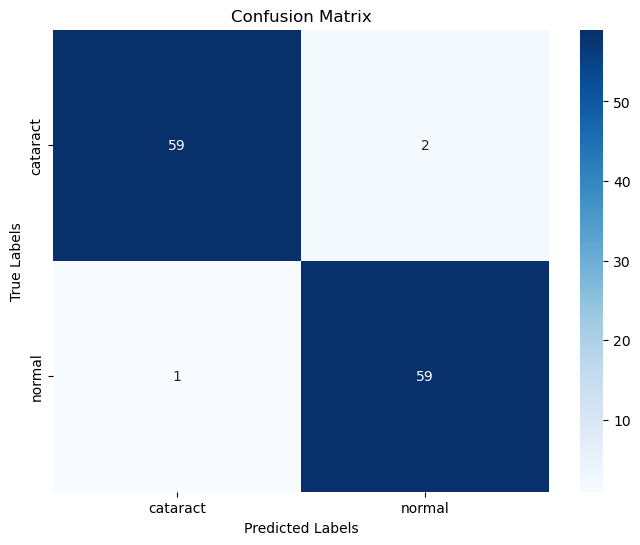

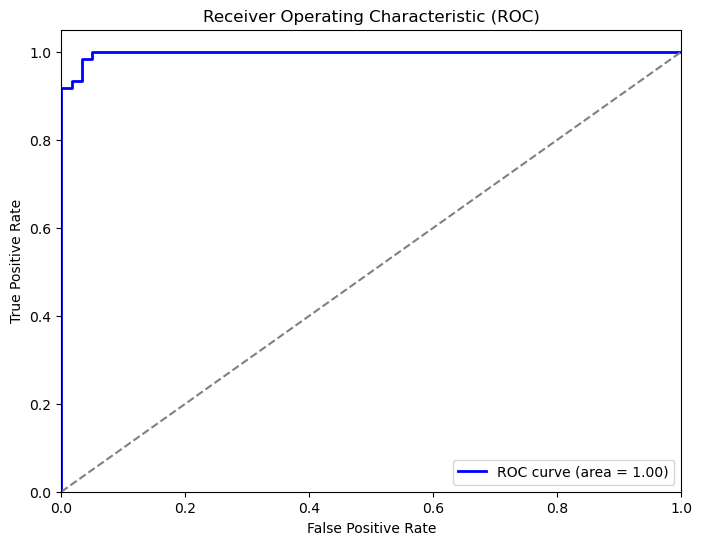

In [8]:
# Import libraries

import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

# Define the directory paths
base_dir = 'processed_images'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Initialize the ImageDataGenerator with enhanced data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    rescale=1/255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Initialize the ImageDataGenerator for testing (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Create training and testing data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure test data is not shuffled
)

# Input shape
input_shape = (224, 224, 3)

# Load the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with an initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_v10.keras', monitor='val_loss', save_best_only=True)

# Train the model with frozen base layers
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model from training
model.load_weights('best_model_v10.keras')

# Fine-tune the model: Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model to apply changes
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuned layers
history_fine_tuning = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)


# Save the final model (architecture + weights) in .keras format
final_model_path = 'final_model_v1.keras'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")


# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Get the predicted probabilities and true labels
test_predictions_prob = model.predict(test_generator)
test_predictions = (test_predictions_prob > 0.5).astype(int).flatten()
test_labels = test_generator.classes

# Generate the classification report
report = classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(test_labels, test_predictions_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
